# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 2 - Clustering




**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner 


<hr style="height:2pt">

### Homework 2 is due February 20th

In [12]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- This is individual homework - No collaboration/Groups
- Problem 1 + Problem 2 = 75 points ; Problem 3 = 25 points
- To submit your assignment, please follow the instructions on Canvas.
- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

### Please use the libraries below:

In [13]:
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hac
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from gap_statistic import OptimalK
#from sklearn.datasets.samples_generator import make_blobs


<hr style="height:2pt">

<div class="theme">*Handy* Algorithms </div>


    
In this assignment, you will be working with data collected from a motion capture camera system. The system was used to record 14 different users performing 5 distinct hand postures with markers attached to a left-handed glove. A set of markers on the back of the glove was used to establish a local coordinate system for the hand, and 8 additional markers were attached to the thumb and fingers of the glove. A total of 24 features were collected based on observations from the camera system. Two other variables in the dataset were the ID of the user and the posture that the user made.

These data have been preprocessed, including transformation to the local coordinate system of the record, removal of outliers, and removal of missing data.

The dataset `postures_clean.csv` contains 38,943 rows and 26 columns. Each row corresponds to a single frame as captured by the camera system. The data are represented in the following manner:

`Class (type: Integer). The hand posture of the given observation, with`

`1 = Fist (with thumb out)`

`2 = Stop (hand flat)`

`3 = Point1 (point with index finger)`

`4 = Point2 (point with index and middle fingers)`

`5 = Grab (fingers curled as if to grab)`

`User (type: Integer). The ID of the user that contributed the record.`

`X0, Y0, Z0, X1, Y1, Z1,..., X7, Y7, Z7 (type: Real). The x-coordinate, y-coordinate, and z-coordinate of the eight unlabeled marker positions.`


Start by reading the dataset into a pandas data frame.

In [14]:
#your code here
posture = pd.read_csv('./data/postures_clean.csv')

<div class='exercise'>Problem 1: Clustering with k-means </div>

(a) After appropriate pre-processing (but not scaling) run the k-means clustering algorithm, using the `KMeans` class from sklearn.cluster, with the number of clusters corresponding to the number of users, `n_init` of 46, and 109 as the random seed. Add the result as a new column called `Cluster14` to your data frame.

In [15]:
#your code here
from sklearn.decomposition import PCA
feature_columns = [colname for colname in list(posture.columns) if colname not in {'Class','User','Cluster14','Cluster5'}]
features_only = posture[feature_columns]
fitted_pca = PCA().fit(posture)
posture_pca =  pd.DataFrame(fitted_pca.transform(posture),columns = ["PCA{}".format(i) for i in range(len(posture.columns.values))])
ms_kmeans = KMeans(n_clusters=14, init='random', n_init=46, random_state=109).fit(posture)

In [16]:
posture['Cluster14'] = ms_kmeans.labels_

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Q1a 
</span></div><div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>Your notebook should be a self-contained report that takes the data analysis from start to finish. It does not make sense to exclude variables for Cluster14 and Cluster5 because those should not have been created to begin with - your code needs to be able to run from start to finish. 
</span></div><div class='alert alert-block alert-danger'><b>Deduction : </b><span style = 'color:black'>-3</span></div></div>

(b) Use the function below to visualize the results for k-means on a random sample of 2,000 observations (it will take the sample for you). Does 14 clusters seem to make sense?

In [18]:
from sklearn.decomposition import PCA

def plot_clusters(full_data, group_col, scaling_mode):
    marker_types = [".", "v", "1", "^", "s", "p", "P", "3", "H", "<", "|", "_", "x", "*"]
    marker_colors = np.concatenate([np.array(plt.cm.tab10.colors),np.array(plt.cm.Pastel1.colors)])
    
    feature_columns = [colname for colname in list(full_data.columns) if colname not in {'Class','User','Cluster14','Cluster5'}]
    features_only = full_data[feature_columns]
    
    # make a scaled df if needed, (but don't scale cluster labels)
    if scaling_mode == True:
        scaler = StandardScaler()
        scaled_features = pd.DataFrame(scaler.fit_transform(features_only), columns=feature_colummns)
    elif scaling_mode == False:
        scaled_features = features_only
    else:
        raise ValueError("Unexpected value for scaling_mode")

    # fit PCA to the whole scaled data
    fitted_pca = PCA().fit(scaled_features)

    # take a sample of the whole scaled data
    scaled_sample = scaled_features.sample(2000, random_state=109)

    # apply the PCA transform on the sample
    pca_sample = pd.DataFrame(fitted_pca.transform(scaled_sample), columns = ["PCA{}".format(i) for i in range(len(scaled_sample.columns.values))])
    
    
    # re-include a cluster label for the pca data
    if 'Cluster14' in full_data.columns.values:
        pca_sample['Cluster14'] = full_data.loc[pca_sample.index, "Cluster14"]
    if 'Cluster5' in full_data.columns.values:
        pca_sample['Cluster5'] = full_data.loc[pca_sample.index, "Cluster5"]
    
    plt.figure(figsize=(11,8.5))
    for i, (cluster_id, cur_df) in enumerate(pca_sample.groupby([group_col])):

        pca1_scores = cur_df.iloc[:,0]
        pca2_scores = cur_df.iloc[:,1]
        plt.scatter(pca1_scores, pca2_scores, label=cluster_id, c=marker_colors[i].reshape(1,-1), marker=marker_types[i])

    plt.xlabel("PC1 ({}%)".format(np.round(100*fitted_pca.explained_variance_ratio_[0],1)))
    plt.ylabel("PC2 ({}%)".format(np.round(100*fitted_pca.explained_variance_ratio_[1],1)))
    plt.legend()
    plt.show()

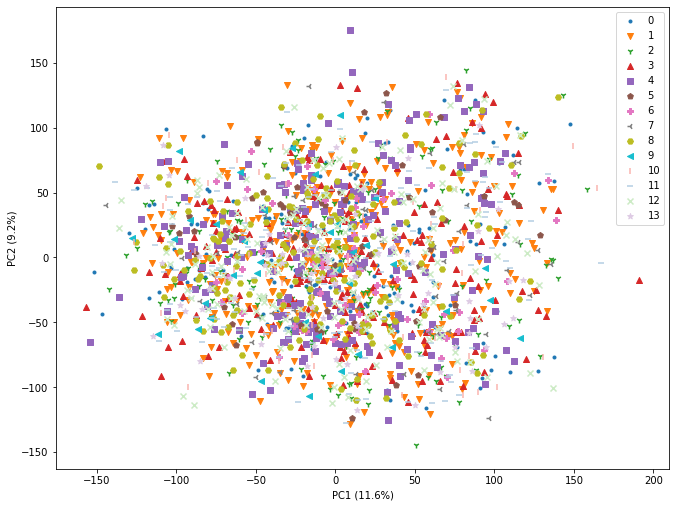

In [23]:
#your code here
plot_clusters(features_only, posture.Cluster14, False)

your response here
### It does not make sense. We are expecting the data been clearly divided into several partitions in the plane, but the plot of clustering show us that the boundary between each cluster is non-linear and vague. Cluserting does not summarize the structure of the data at all. ###

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Q1b 
</span></div><div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>An analysis based on this visual should consider the % variance explained and discuss PCA more generallly. Should also be clear that it does not visually create separation in two dimensions only (as this is what is seen thus far). 
</span></div><div class='alert alert-block alert-danger'><b>Deduction : </b><span style = 'color:black'>-2</span></div></div>

(c) Plot the silhouette scores using the function below, from lecture. Give it a 10% sample of the data to speed the visualization. How reasonable does the clustering seem based on this plot? How does it compare to the information in the plot above?

In [25]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
#modified code from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

def silplot(X, cluster_labels, clusterer, pointlabels=None):
    n_clusters = clusterer.n_clusters
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(11,8.5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters = ", n_clusters,
          ", the average silhouette_score is ", silhouette_avg,".",sep="")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(0,n_clusters+1):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=200, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    xs = X[:, 0]
    ys = X[:, 1]
    
    if pointlabels is not None:
        for i in range(len(xs)):
            plt.text(xs[i],ys[i],pointlabels[i])

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % int(i), alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

/Users/xuehao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


For n_clusters = 14, the average silhouette_score is 0.06680228680287974.


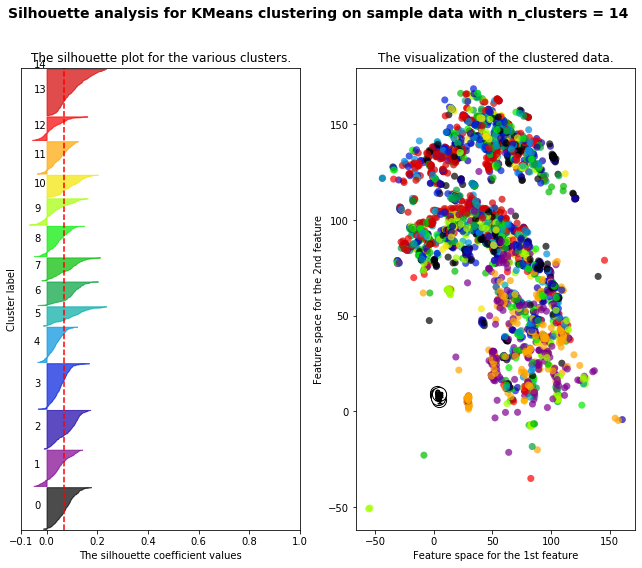

In [26]:
#your code here
features_only['Cluster14'] = posture.Cluster14
mysample = features_only.sample(n=int(0.1*posture.shape[0]),random_state=109) 
silplot(mysample.values, mysample.Cluster14, ms_kmeans, pointlabels=None)

your response here
### According to the plot above, this clustering still does not make sense. Firstly, the left panel implies that in cluster 12,11,8,7,6,5,4,3,2,1 and 0, there are more than one sample having Sihouette score less than 0, suggesting that they might be incorrectly clustered. The average Sihouette score is around 0.07, close to zero, which implies that the cluserting is not good.  Secondly, the righ panel suggests that the margin between different cluster is very small and clusters highly overlap with each other and their centroids coincide. The information we observe supports the information provided by the plot above that 14 clusters may be too many and the clustering is not good.   

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Q1c 
</span></div><div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>Recall that even some "good" clustering might at some points have a few points with negative silhouettes, as the creation and evaluation of clusters do not always use the same (distance) metric. See solutions here for your visuals. 
</span></div><div class='alert alert-block alert-danger'><b>Deduction : </b><span style = 'color:black'>-2</span></div></div>

(d) Repeat all of the above steps, but attempting to group by posture rather than by user. That is : 

(i) Run the k-means algorithm with 5 centroids instead of 14, creating a variable named `Cluster5` and adding it to the dataset. 

(ii) Visualize the results for k-means. Does 5 clusters seem to make sense from this plot?

(iii) Plot the silhouette scores on a 10% sample of the data. How reasonable does the clustering seem based on this plot?

/Users/xuehao/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


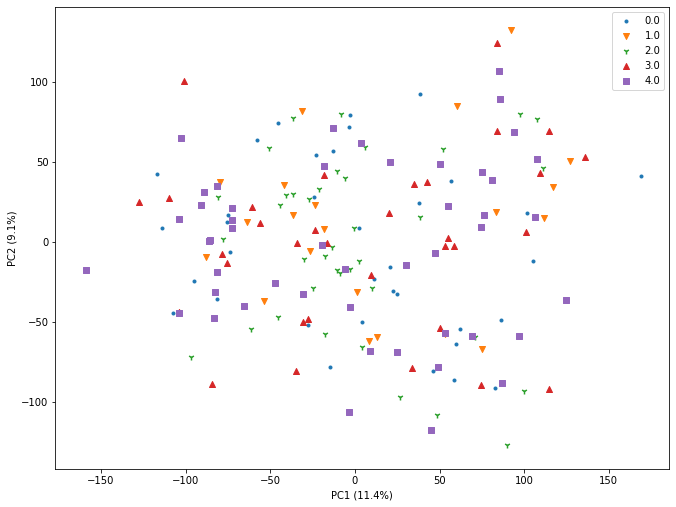

In [28]:
#your code here
kmeans5 = KMeans(n_clusters=5, init='random', n_init=46, random_state=109).fit(mysample)
mysample['Cluster5'] = kmeans5.labels_
plot_clusters(mysample, 'Cluster5', False)

your response here
### 5 clusters still does not make sense from this plot as we cannot see a clear margin or a clear partition between different clusters. 

For n_clusters = 5, the average silhouette_score is 0.07105542159518649.


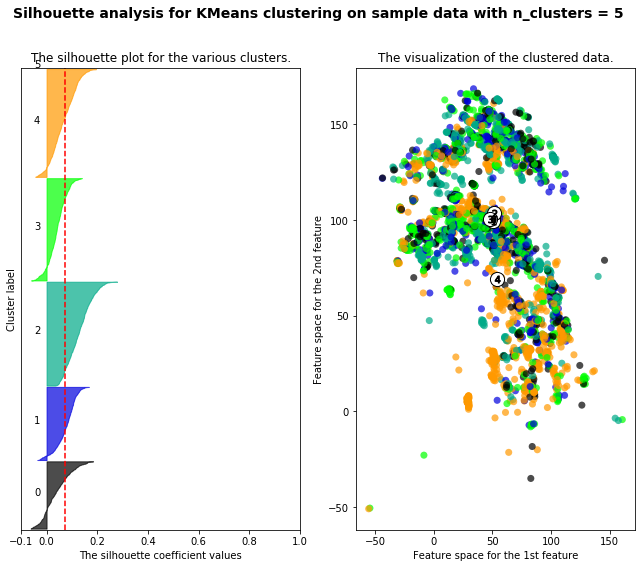

In [32]:
#your code here
silplot(mysample.values, mysample.Cluster5, kmeans5, pointlabels=None)

your response here
### The 5 clustering seems to be more reasonbale than the 14 clusters. However, it still suffers from similar problems, which make this clustering still invalid. Firstly, the left panel implies that in cluster 4,3,1 and 0, there are more than one sample having Sihouette score less than 0, suggesting that they might be incorrectly clustered. The average Sihouette score is around 0.07, close to zero, which implies that the cluserting is not good.  Secondly, the righ panel suggests that the margin between different cluster is very small and clusters highly overlap with each other and their centroids coincide. As a conclusion, the clustering is better but not good enough.

(e) What do the results suggest? Does this make sense in the context of what we know about the problem?

your response here

### This result suggests that neither 5 nor 12 clusters properly cluster our data since they return low Silhouette score and which suggests that the clustering may be wrong. The results suggest that there is no similarity interms of positions of markers within users or gesture types. Even though it contradicts with our prior belief that the our data should be similar among the same type of posture or user, this results still make sense, it is likely that the positions of markers are indepdent to both users and types of gesture. It is also possible that there may be actually less clusters. Another potential explaination is that the there may be other feature or statistics that may be helpful for clustering but we did not include. 

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Q1e 
</span></div><div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>Overall well done on Q1, in tying back to the original question (5 postures and 14 users) as well 
</span></div></div>

<div class='exercise'> <b> Problem 2: Other Ks  </b> </div>

In the previous problem, we examined the results of running k-means with 5 and 14 centroids on the postures data. In this problem, we will investigate a broader range of possible cluster sizes, with a borader range of metrics. 

**For all of these questions, you should work with a sample of 2,000 data points drawn with `pd.sample` and a random seed of 109.**

(a) Use the elbow method to evaluate the best choice of the number of clusters, plotting the total within-cluster variation against the number of clusters, for k-means clustering with $k \in \{1,2,...,15\}.$
 

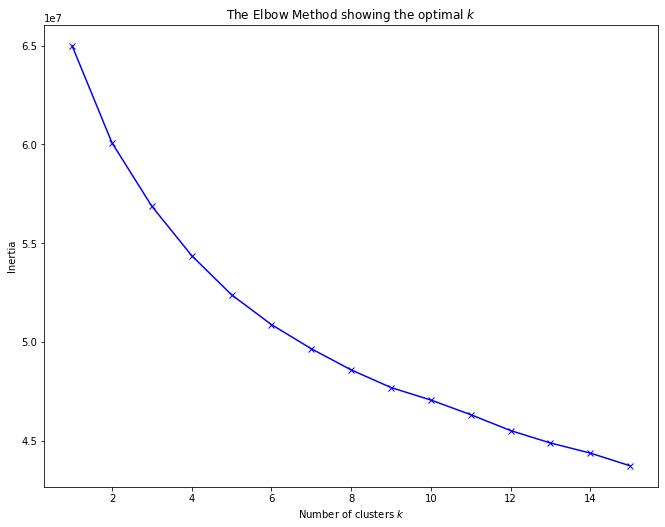

In [6]:
#your code here
feature_columns = [colname for colname in list(posture.columns) if colname not in {'Class','User','Cluster14','Cluster5'}]
features_only = posture[feature_columns]
sample_features_only = posture.sample(n=2000,random_state=109)
wss = []
for i in range(1,16):
    fitx = KMeans(n_clusters=i, init='random', n_init=5, random_state=109).fit(sample_features_only)
    wss.append(fitx.inertia_)

plt.figure(figsize=(11,8.5))
plt.plot(range(1,16), wss, 'bx-')
plt.xlabel('Number of clusters $k$')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal $k$')
plt.show()

### From the plot we can see that teh bend occurs at around 4 or 5. Therefore, the Elbow method gives us the optimal clusters should be 4 or 5.

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Q2a
</span></div><div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>Good job using features dataframe correclty here 
</span></div></div>

(b) Use the average silhouette to evaluate the choice of the number of clusters for k-means clustering with $k \in \{1,2,...,15\}$. Plot the results. 

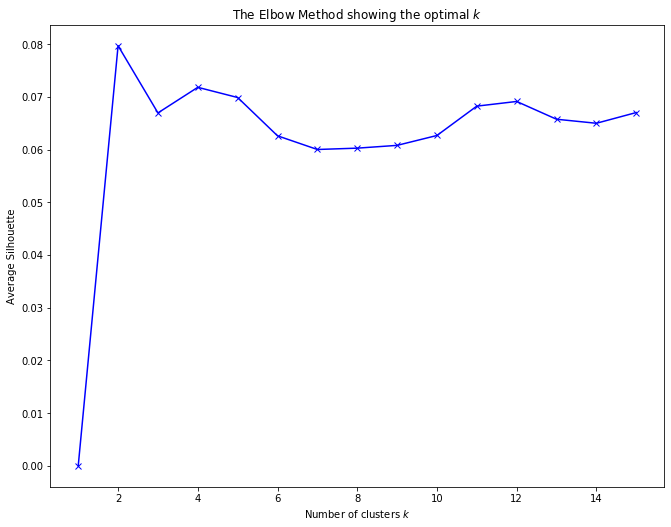

In [32]:
#your code here
from sklearn.metrics import silhouette_score

scores = [0]
for i in range(2,16):
    fitx = KMeans(n_clusters=i, init='random', n_init=5, random_state=109).fit(sample_features_only)
    score = silhouette_score(sample, fitx.labels_)
    scores.append(score)
    
plt.figure(figsize=(11,8.5))
plt.plot(range(1,16), np.array(scores), 'bx-')
plt.xlabel('Number of clusters $k$')
plt.ylabel('Average Silhouette')
plt.title('The Elbow Method showing the optimal $k$')
plt.show()

### The optimal average Silhouette score occurs at around 2, suggesting that 2 is the optimcal number of clusters in this metric.

(c) Use the gap statistic to evaluate the choice of the number of clusters for k-means clustering with $k \in \{1,2,..,15\}$. Plot the results. 

Optimal clusters:  15


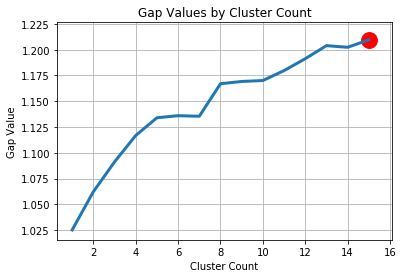

In [61]:
#your code here
from gap_statistic import OptimalK
from sklearn.datasets.samples_generator import make_blobs

gs_obj = OptimalK()

n_clusters = gs_obj(sample_features_only.values, n_refs=50, cluster_array=np.arange(1, 16))
print('Optimal clusters: ', n_clusters)
plt.plot(gs_obj.gap_df.n_clusters, gs_obj.gap_df.gap_value, linewidth=3)
plt.scatter(gs_obj.gap_df[gs_obj.gap_df.n_clusters == n_clusters].n_clusters,
            gs_obj.gap_df[gs_obj.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

### The optimal clusters by gat statistic is 15.

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Q2c 
</span></div><div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>Remember the formula that Mark discussed in lecture including the standard deviation of one cluster more, revisit this in the lecture notes if you are unsure. Optimal clusters is not 15. 
</span></div><div class='alert alert-block alert-danger'><b>Deduction : </b><span style = 'color:black'>-3</span></div></div>

(d) After analyzing the plots produced by all three of these measures, discuss the number of k-means clusters that you think is the best fit for this dataset. Defend your answer with evidence from the previous parts of this question, the three graphs produced here, and what you surmise about this dataset.

your response here
### I would choose 2 clusters given by the average Silhouette score metric as the number of k-means clusters that best fit for this dataset. From previous analysis we can see, the results given by 5 or 14 clusters are not satisfactory and they failed to capture the similarity between data. Even though 5 and 14 are optimal number of clusters given by gap statistic and inertia, the elbow method is informal(and somewhat ad hoc), we should make judgement based on the fact that there are always some samples having negative Silhouette score in each clusters under both scenarios, which implies that the clustering may not be correct. Hence, we should be more conservative in doing clustering and avoid cluster data into the group they don't belong to. I guess it is possible that this data is highly noisy so that different clustering criteria gives us different number of optimal clusters.

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Q2d 
</span></div><div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>Good analysis here. Your decision is certainly supported by these visuals. 
</span></div></div>

<div class='exercise'> <b> Problem 3: Alternative Algorithms  </b> </div>

(e) Run DBSCAN on the data. How many clusters are found, and how well does this clustering perform on e.g. silhouette score, excluding the points not assigned to any cluster?  
*Note*: Do not use a sample of the data. Running the algorithm may take up to 5-10 minutes.

In [36]:
#your code here
from sklearn.cluster import DBSCAN
from sklearn import metrics
#posture_pca.drop(['Cluster14','Cluster5'],axis=1)
fitted_dbscan = DBSCAN(eps=150).fit(features_only)

array([-1,  0,  1,  2,  3])

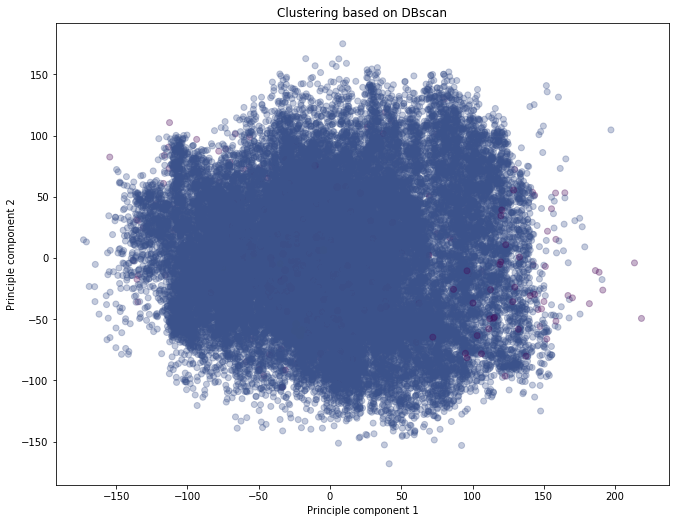

In [43]:
plt.figure(figsize=(11,8.5))
#metrics.silhouette_score(posture_pca, fitted_dbscan.labels_, metric='sqeuclidean')
plt.scatter(posture_pca.values[:,0],posture_pca.values[:,1], c=fitted_dbscan.labels_,alpha=0.3);
plt.xlabel('Principle component 1')
plt.ylabel('Principle component 2')
plt.title('Clustering based on DBscan')
np.unique(fitted_dbscan.labels_)

In [40]:
score = silhouette_score(features_only, fitted_dbscan.labels_)
print(score)

0.04740538664816651


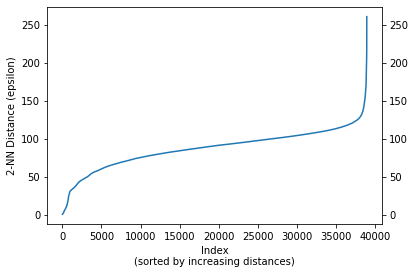

In [41]:
from sklearn.neighbors import NearestNeighbors
def plot_epsilon(df, min_samples):
    fitted_neigbors = NearestNeighbors(n_neighbors=min_samples).fit(df)
    distances, indices = fitted_neigbors.kneighbors(df)
    dist_to_nth_nearest_neighbor = distances[:,-1]
    plt.plot(np.sort(dist_to_nth_nearest_neighbor))
    plt.xlabel("Index\n(sorted by increasing distances)")
    plt.ylabel("{}-NN Distance (epsilon)".format(min_samples-1))
    plt.tick_params(right=True, labelright=True)

plot_epsilon(features_only, 3)

### I plot the average distance from the 3rd nearest neighbor for each point and observe a knee at around 150. Then I run DBscan with epsilon = 150. It returns 5 clusters with Silhoette score around 0.05. Compared to KNN, the Silhoette score of DBscan is lower, whci suggest that knn might outperform the DBscan method. However, we could further tune the epsilon from around 50 to 250 to optimize the Silhouette score.

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Q3a 
</span></div><div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>Cell 43 is a very nice visual! It would be nice to have more color differentiation, or perhaps shape differentiation (I don't see color super well) (no points removed for this, but just something to keep in mind). I would be interested in seeing scatter points which appear in the "center" in the first two dimensions. It does seem like some scatter are outliers even in the first two dimensions. Great idea to show this! Unclear where, or if, you are dropping -1 because your cells are not in a logical order and it seems cells might have been deleted here perhaps. 
</span></div><div class='alert alert-block alert-danger'><b>Deduction : </b><span style = 'color:black'>-3</span></div></div>

(f) Hierarchical clustering. Run agglomerative clustering (using Ward's method), and plot the result using a dendrogram. Interpret the results, and describe the cluster size(s) the plot suggests. What level of aggregation is suggested by the sihoutte score?

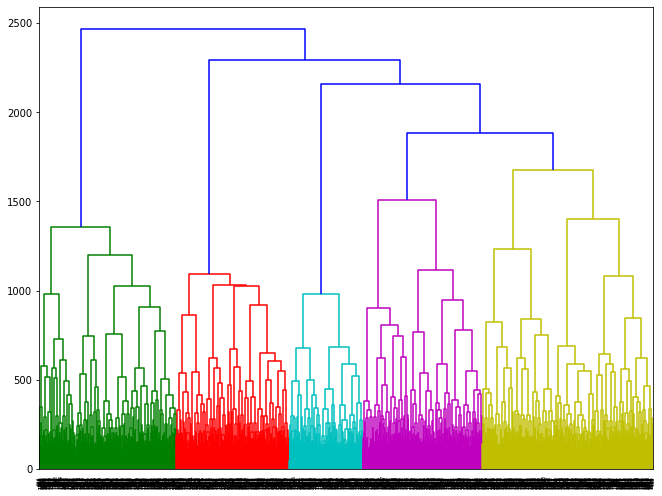

In [10]:
#your code here
plt.figure(figsize=(11,8.5))
dist_mat = pdist(sample_features_only, metric="euclidean")
ward_data = hac.ward(dist_mat)
hac.dendrogram(ward_data);

your response here
 Interpret the results, and describe the cluster size(s) the plot suggests. What level of aggregation is suggested by the sihoutte score?
### The y-axis measures the distance between nidividual or clusters, the x-axis are each individual. With the distance between each pair of samples computed, agglomerative clustering algorithm joind them into groups "from bottom to up". This method suggests that there may be five clusters.  

In [60]:
#your code here
from sklearn.cluster import AgglomerativeClustering 
for i in range(2,15):
    ac3 = AgglomerativeClustering(n_clusters = i)
    score = silhouette_score(sample_features_only, ac3.fit_predict(sample_features_only))
    print("silhouette_score for " + str(i)+ " clusters is: "+str(score))

silhouette_score for 2 clusters is: 0.05143238029946454
silhouette_score for 3 clusters is: 0.046784684200490735
silhouette_score for 4 clusters is: 0.023374536360494847
silhouette_score for 5 clusters is: 0.02921136891963629
silhouette_score for 6 clusters is: 0.0318197245956575
silhouette_score for 7 clusters is: 0.03341246409738656
silhouette_score for 8 clusters is: 0.026471845757702225
silhouette_score for 9 clusters is: 0.030206873723825092
silhouette_score for 10 clusters is: 0.030578080220246825
silhouette_score for 11 clusters is: 0.03181499840073058
silhouette_score for 12 clusters is: 0.03243185529105594
silhouette_score for 13 clusters is: 0.03505611792543151
silhouette_score for 14 clusters is: 0.03732734943478952


your response here
### As we can see that he Silhouette score is the highest when clustering number is 2 for Hierarchical clustering.

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Q3b 
</span></div><div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>Your approach here is very methodical. It is clear that you are thinking throughout this homework instead of just "turning on autopilot" and repeating things done in lecture/lab. You explain agglomorative in your own words well - there might also be something gained by the silhouette.Would be nice to know your opinion based on the visual itself though. Should remove the black blob of labels at the bottom of the visual, as it isn't adding thing and is just a confusion to comeone unfamiliar with the problem 
</span></div></div>

(g) Overall, what do you conclude about the number and kind of clusters in this data set?

your response here
The elbow method using inertia, DBscan and agglomerative clustering suggest that there are supposed to be five clusters. But the their Silhouette score is very low. I would prefer using KNN with 2 clusters as it gives the highest Silhouette score 0.07 and we should be more conservative in finding when we dont get significant signal. 

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Q3c 
</span></div><div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>Preference for fewer clusters (2) is certainly defensible. I appreciate that you lay this out as your opinion as a data scientist and the benefits of being conservative in your findings - I think there's a good case to be made that classifying things as separate clusters when "in truth" they are not is worse than failing to split apart one "cluster" into two. Well done here, again I appreciate your analysis. 
</span></div></div>

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>QOverall 
</span></div><div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>In the future be sure to go to kernel and then restart-and-run-all as directed at the top of the homework, in future HWs there will be deductions for this. Your work is generally good thoughout, but there are a few key points where you might be misunderstanding the procedure - check out the solutions notebook. Your personal approach to this HW is certainly appreciated! I always advise that if you are embarking on a supplementary analysis to support your answer, make sure to also include the more basic answer that the question is asking too! (don't want you to lose points in future HWs for your personal style of data analysis, but of course we are evaluating on these methods to be consistent across all students - just make sure your work is supplementary *after* you do the main question asked) 
</span></div></div>

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#999; background:#fff;">
Graded by: Evan MacKay
</footer>